In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

print("numpy version:", np.__version__)
print("tensorflow version:", tf.__version__)
print("pandas version:", pd.__version__)

numpy version: 1.13.3
tensorflow version: 1.4.0
pandas version: 0.19.2


## Parsing the SkillCraft dataset from CSV

The first step is to get the data into a form Python can manipulate. Might be worth converting the data and saving it in .npz format as a one-time operation.

There are 20 attributes in the dataset but the authors really only use fields 6-20. Hence it didn't matter that some rows exist with '?' in one or more attributes which need to be filtered out at least for some learning. Might be interesting to predict their values.

Looking more closely at the data, there exist 3395 records (vs 3305+55 used in paper). This discrepancy is because 35 'Grandmaster' games were dropped and 55 'Professional' games were added. 57 of these records contain at least one missing attribute. These are rows 360, 1843, 3342-3396. However, these attributes "Age", "TotalHours", "HoursPerWeek" were not used in the study.

In [2]:
# with open('SkillCraft1_Dataset.csv', 'rb') as skillcraft:
#     # default delimiter=',' and quotechar='"'
#     reader = csv.DictReader(skillcraft)
#     for row in reader:
#         print(row)

In [3]:
skillcraft = pd.read_csv('SkillCraft1_Dataset.csv')
print(type(skillcraft))

<class 'pandas.core.frame.DataFrame'>


In [4]:
print(pd.unique(skillcraft['LeagueIndex']))
# skillcraft.query('LeagueIndex != 7')

[5 4 3 2 1 7 6 8]


Currently keeping Grandmaster games even though paper discarded them.

In [5]:
data = skillcraft.iloc[:, 5:]
print(type(data))
print(data.shape)
print(data.iloc[3393])

<class 'pandas.core.frame.DataFrame'>
(3395, 15)
APM                     375.866400
SelectByHotkeys           0.036436
AssignToHotkeys           0.000594
UniqueHotkeys             5.000000
MinimapAttacks            0.000204
MinimapRightClicks        0.000780
NumberOfPACs              0.004346
GapBetweenPACs           11.691000
ActionLatency            34.854700
ActionsInPAC              7.961500
TotalMapExplored         15.000000
WorkersMade               0.000613
UniqueUnitsMade           6.000000
ComplexUnitsMade          0.000000
ComplexAbilitiesUsed      0.000631
Name: 3393, dtype: float64


The leagues should be the labels/targets.

In [6]:
target = skillcraft.iloc[:, 1]
print(type(target))
print(target.shape)

<class 'pandas.core.series.Series'>
(3395,)


In [7]:
data = data.values
print(type(data))
print(data.shape)

<type 'numpy.ndarray'>
(3395, 15)


In [8]:
target = target.values
print(type(target))
print(target.shape)

<type 'numpy.ndarray'>
(3395,)


In [9]:
np.random.seed(45689)
rnd_idx = np.arange(np.shape(data)[0])
np.random.shuffle(rnd_idx)

trBatch = int(np.ceil(0.8*len(rnd_idx)))
validBatch = int(np.ceil(0.1*len(rnd_idx)))

trainData, validData, testData = (data[rnd_idx[0:trBatch],:],
                                  data[rnd_idx[trBatch:trBatch + validBatch],:],
                                  data[rnd_idx[trBatch + validBatch:],:])

trainTarget, validTarget, testTarget = (target[rnd_idx[0:trBatch]],
                                        target[rnd_idx[trBatch:trBatch + validBatch]],
                                        target[rnd_idx[trBatch + validBatch:]])

In [10]:
# np.random.seed(45689)
# rnd_idx = np.arange(np.shape(data)[0])
# np.random.shuffle(rnd_idx)

# # trBatch = int(np.ceil(0.8*len(rnd_idx)))
# # validBatch = int(np.ceil(0.1*len(rnd_idx)))
# trBatch = 3050

# trainData, testData = (data[rnd_idx[0:trBatch],:],
#                        data[rnd_idx[trBatch:],:])

# trainTarget, testTarget = (target[rnd_idx[0:trBatch]],
#                            target[rnd_idx[trBatch:]])

In [11]:
print("trainData shape:", trainData.shape)
print("trainTarget shape:", trainTarget.shape)
print("validData shape:", validData.shape)
print("validTarget shape:", validTarget.shape)
print("testData shape:", testData.shape)
print("testTarget shape:", testTarget.shape)

trainData shape: (2716, 15)
trainTarget shape: (2716,)
validData shape: (340, 15)
validTarget shape: (340,)
testData shape: (339, 15)
testTarget shape: (339,)


Checking the label distributions.

In [12]:
print(trainData.dtype)
print(trainTarget.dtype)

# decrementing each ordinal value by one in order to one-hot encode each record
trainTarget = trainTarget-1
validTarget = validTarget-1
testTarget = testTarget-1

print(np.unique(trainTarget))
print(np.unique(validTarget))
print(np.unique(testTarget))
print(np.bincount(trainTarget))
print(np.bincount(validTarget))
print(np.bincount(testTarget))

float64
int64
[0 1 2 3 4 5 6 7]
[0 1 2 3 4 5 6 7]
[0 1 2 3 4 5 6 7]
[130 280 449 639 654 494  28  42]
[20 33 56 85 72 66  4  4]
[17 34 48 87 80 61  3  9]


In [13]:
# need to expand the targets (currently just a scalar) into a one-hot 10-D vector
# code from https://stackoverflow.com/a/42874726/8346497
classes = np.unique(trainTarget).shape[0]
trainTarget = np.eye(classes)[trainTarget]
validTarget = np.eye(classes)[validTarget]
testTarget = np.eye(classes)[testTarget]

print("new trainTarget shape:", trainTarget.shape)
print("new validTarget shape:", validTarget.shape)
print("new testTarget shape:", testTarget.shape)

new trainTarget shape: (2716, 8)
new validTarget shape: (340, 8)
new testTarget shape: (339, 8)


## Experiment 1: Predict Rank/League of Player

This is a classification task, so let's use logistic regression (but the paper says there are "assumptions about the structure of the relationship between the predictive variables and the response") and neural nets.

Using only attributes 6-20, just like the paper.

Let's see how well the neural net can do for 8-way classification.

In [14]:
def build_layer(incoming, num_hidden_units):
    """
    incoming: the input tensor containing the hidden activations from previous layer
    num_hidden_units: the number of hidden units for this layer
    
    takes the hidden activations from the previous layer and then returns the weighted sum of
    the inputs for the current hidden layer (before passing through activation)
        
    also return the weights W_layer for regularization
    """
    # Xavier initialization
    num_input_units = incoming.get_shape().as_list()[1]
    variance = 3. / (num_input_units + num_hidden_units)
    
    W_layer = tf.Variable(tf.truncated_normal(shape=[num_input_units, num_hidden_units], stddev=tf.sqrt(variance)))
    b_layer = tf.Variable(tf.constant(0.0, shape=[num_hidden_units]))
    
    # the output of this hidden layer
    layer = tf.matmul(incoming, W_layer) + b_layer
    return layer, W_layer

In [15]:
X = tf.placeholder(tf.float32, shape=[None, trainData.shape[1]])
y_target = tf.placeholder(tf.float32, shape=[None, trainTarget.shape[1]])

# input to hidden layer
hidden_layer_in, W_layer1 = build_layer(X, 1000)
keep_prob = tf.placeholder(tf.float32)
hidden_layer_out = tf.nn.dropout(tf.nn.relu(hidden_layer_in), keep_prob)

# hidden layer to output
y_predicted, W_layer2 = build_layer(hidden_layer_out, trainTarget.shape[1])

# perform a softmax on the output layer
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_target, logits=y_predicted))

# add L2 norm penalty for every weight in the network
penalty = 0.0
regularizers = tf.nn.l2_loss(W_layer1) + tf.nn.l2_loss(W_layer2)
cross_entropy += penalty * regularizers

In [16]:
global_step = tf.Variable(0, trainable=False)
eta_0 = 1e-3
eta = tf.train.exponential_decay(eta_0, global_step, 5000, 0.9, staircase=True)

optimizer = tf.train.AdamOptimizer(learning_rate=eta)
train = optimizer.minimize(cross_entropy, global_step=global_step)
y_class_predicted = tf.argmax(y_predicted, 1)
y_class_target = tf.argmax(y_target, 1)
errors = tf.reduce_sum(tf.cast(tf.not_equal(y_class_predicted, y_class_target), tf.float32))

In [21]:
batch_size=256

train_errors = []
valid_errors = []
test_errors = []
train_xentropy_losses = []
valid_xentropy_losses = []
test_xentropy_losses = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    i=0

    for step in range(1, 10001):
        if i >= trainData.shape[0]:
            i -= trainData.shape[0]
            train_error, train_loss = sess.run([errors, cross_entropy],
                                                feed_dict={X: trainData.take(indices, axis=0, mode='wrap'),
                                                           y_target: trainTarget.take(indices, axis=0, mode='wrap'),
                                                           keep_prob: 1.0})
            valid_error, valid_loss = sess.run([errors, cross_entropy],
                                                feed_dict={X: validData, y_target: validTarget,
                                                           keep_prob: 1.0})
            test_error, test_loss = sess.run([errors, cross_entropy],
                                              feed_dict={X: testData, y_target: testTarget,
                                                         keep_prob: 1.0})
            train_xentropy_losses.append(train_loss)
            train_errors.append(train_error)
            valid_xentropy_losses.append(valid_loss)
            valid_errors.append(valid_error)
            test_xentropy_losses.append(test_loss)
            test_errors.append(test_error)

        indices = range(i, i+batch_size)
        _, loss = sess.run([train, cross_entropy], feed_dict={X: trainData.take(indices, axis=0, mode='wrap'),
                                                              y_target: trainTarget.take(indices, axis=0, mode='wrap'),
                                                              keep_prob: 0.5})
        i += batch_size

        if (step % 500 == 0):
            train_error, train_loss = sess.run([errors, cross_entropy],
                                                feed_dict={X: trainData.take(indices, axis=0, mode='wrap'),
                                                           y_target: trainTarget.take(indices, axis=0, mode='wrap'),
                                                           keep_prob: 1.0})
            valid_error, valid_loss = sess.run([errors, cross_entropy],
                                                feed_dict={X: validData, y_target: validTarget,
                                                           keep_prob: 1.0})
            test_error, test_loss = sess.run([errors, cross_entropy],
                                              feed_dict={X: testData, y_target: testTarget,
                                                         keep_prob: 1.0})
            print("Iter: %4d, x-train: %4.5f, x-valid: %4.5f, x-test: %4.5f, Train errs: %d, Valid errs: %d, Test errs: %d"%
                  (step, train_loss, valid_loss, test_loss, train_error, valid_error, test_error))

Iter:  500, x-train: 1.32027, x-valid: 1.42703, x-test: 1.45055, Train errs: 155, Valid errs: 208, Test errs: 231
Iter: 1000, x-train: 1.29012, x-valid: 1.43210, x-test: 1.45084, Train errs: 148, Valid errs: 207, Test errs: 226
Iter: 1500, x-train: 1.34690, x-valid: 1.42805, x-test: 1.45869, Train errs: 143, Valid errs: 207, Test errs: 222
Iter: 2000, x-train: 1.28637, x-valid: 1.43538, x-test: 1.45414, Train errs: 137, Valid errs: 209, Test errs: 218
Iter: 2500, x-train: 1.32621, x-valid: 1.44217, x-test: 1.46736, Train errs: 150, Valid errs: 202, Test errs: 217
Iter: 3000, x-train: 1.27256, x-valid: 1.45167, x-test: 1.45505, Train errs: 136, Valid errs: 209, Test errs: 220
Iter: 3500, x-train: 1.33108, x-valid: 1.44833, x-test: 1.46529, Train errs: 148, Valid errs: 207, Test errs: 221
Iter: 4000, x-train: 1.36389, x-valid: 1.46189, x-test: 1.46125, Train errs: 157, Valid errs: 204, Test errs: 222
Iter: 4500, x-train: 1.25807, x-valid: 1.47034, x-test: 1.45952, Train errs: 149, Valid 

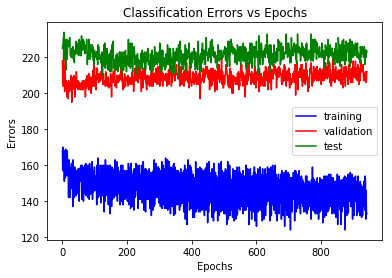

In [22]:
# plot training curve for classification error vs number of epochs
plt.plot(train_errors, 'b-', label='training')
plt.plot(valid_errors, 'r-', label='validation')
plt.plot(test_errors, 'g-', label='test')
plt.title('Classification Errors vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Errors')
plt.legend()

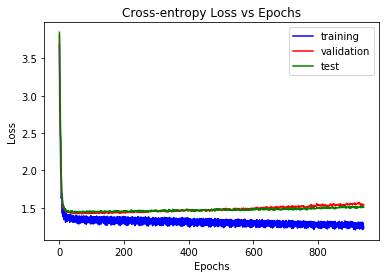

In [23]:
# plot training and validation for cross-entropy loss vs number of epochs
plt.plot(train_xentropy_losses, 'b-', label='training')
plt.plot(valid_xentropy_losses, 'r-', label='validation')
plt.plot(test_xentropy_losses, 'g-', label='test')
plt.title('Cross-entropy Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

## Additional Experiment Ideas

Visualize the data after dimensionality reduction?

Try reproduce results of paper with conditional inference forests (pandas can convert to R objects and then use cforest function in R)? Or look into Tensorflow implementations of random forests...